<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#COCO-examples" data-toc-modified-id="COCO-examples-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>COCO examples</a></span><ul class="toc-item"><li><span><a href="#Basic-structure" data-toc-modified-id="Basic-structure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basic structure</a></span></li><li><span><a href="#BBoxLabeler" data-toc-modified-id="BBoxLabeler-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>BBoxLabeler</a></span></li></ul></li></ul></div>

## COCO examples

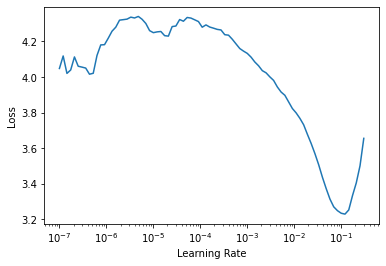

In [ ]:
lr_min, lr_steep = learn.lr_find()

epoch,train_loss,valid_loss,time
0,3.410979,0.829697,00:11
1,2.161541,0.430196,00:11
2,1.107481,0.197013,00:11
3,0.533728,0.120991,00:11
4,0.277986,0.097236,00:11
5,0.176941,0.086604,00:11
6,0.135658,0.084902,00:11
7,0.117474,0.080383,00:11
8,0.111881,0.078642,00:11
9,0.108461,0.078577,00:11


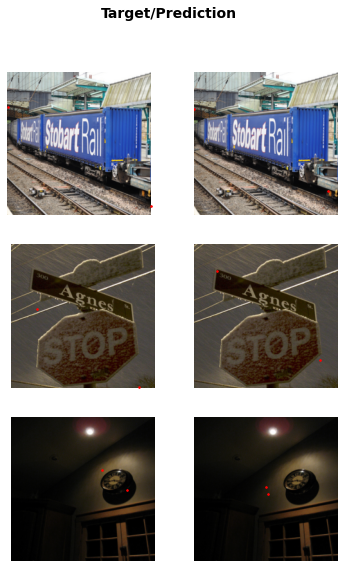

In [ ]:
learn.fit_one_cycle(10, lr=lr_min)
learn.show_results()

### Basic structure

https://docs.fast.ai/vision.core#TensorBBox

Bounding boxes are expected to come as tuple with an array/tensor of shape (n,4) or as a list of lists with four elements and a list of corresponding labels.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn, bbox = coco/'train'/images[idx],lbl_bbox[idx]
coco_fn

Path('/home/rory/.fastai/data/coco_tiny/train/000000153607.jpg')

In [ ]:
bbox # tuple of list-of-lists, list

([[6.33, 34.52, 73.06, 107.28999999999999],
  [76.8, 48.61, 128.0, 122.25],
  [95.42, 4.32, 123.42, 31.93]],
 ['vase', 'vase', 'vase'])

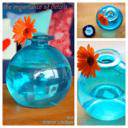

In [ ]:
timg = Transform(PILImage.create)
coco_img = timg(coco_fn)
coco_img

In [ ]:
tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
tbbox

(#2) [TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]),['vase', 'vase', 'vase']]

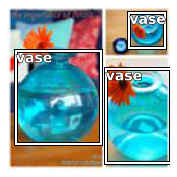

In [ ]:
ctx = coco_img.show(figsize=(3,3))
tbbox.show(ctx=ctx);

### BBoxLabeler

https://docs.fast.ai/vision.core#BBoxLabeler

Delegates (`__call__`,`decode`,`setup`) to (`encodes`,`decodes`,`setups`) if split_idx matches

In [ ]:
def _coco_bb(x):  return TensorBBox.create(bbox[0]) # trivial functions
def _coco_lbl(x): return bbox[1]
_coco_bb(420), _coco_lbl(69*42)

(TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
         [ 76.8000,  48.6100, 128.0000, 122.2500],
         [ 95.4200,   4.3200, 123.4200,  31.9300]]),
 ['vase', 'vase', 'vase'])

In [ ]:
item   = Path('/home/rory/.fastai/data/coco_tiny/train/000000153607.jpg')
bboxes = TensorBBox.create([[ 6.33,34.52, 73.06,107.29],[76.80,48.61,128.00,122.25],[95.42, 4.32,123.42, 31.93]])
lbls   = ['vase', 'vase', 'vase']

def trivial_bbox(x): return bboxes
def trivial_lbls(x): return lbls

dss_tfms = [PILImage.create, # x   can I add brackets and it'll be unchanged?
            [trivial_bbox],  # y1
            [trivial_lbls, MultiCategorize(add_na=True)]] # y2

coco_tds = Datasets([item], tfms=dss_tfms, n_inp=1)
coco_tds

(#1) [(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1]))]

In [ ]:
tdl_tfms = [BBoxLabeler(), PointScaler(), ToTensor()]
coco_tdl = TfmdDL(coco_tds, bs=1, after_item=tdl_tfms)

coco_tdl.tfms

(#3) [Pipeline: PILBase.create,Pipeline: trivial_bbox,Pipeline: trivial_lbls -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}]

In [ ]:
x,y,z = coco_tdl.one_batch()
x,y,z

(TensorImage([[[[255, 249, 255,  ..., 248, 233, 221],
           [255, 255, 251,  ..., 255, 244, 234],
           [252, 249, 207,  ..., 251, 255, 252],
           ...,
           [241, 251, 244,  ..., 217, 255, 255],
           [226, 237, 255,  ..., 254, 255, 255],
           [213, 221, 242,  ..., 254, 255, 255]],
 
          [[254, 243, 255,  ..., 255, 255, 255],
           [252, 254, 255,  ..., 251, 255, 255],
           [253, 255, 223,  ..., 232, 252, 253],
           ...,
           [255, 250, 217,  ..., 232, 250, 246],
           [255, 255, 255,  ..., 255, 253, 251],
           [255, 255, 255,  ..., 248, 250, 254]],
 
          [[236, 231, 251,  ..., 255, 255, 255],
           [242, 250, 255,  ..., 252, 255, 255],
           [255, 255, 239,  ..., 218, 255, 255],
           ...,
           [255, 246, 196,  ..., 229, 251, 249],
           [255, 255, 253,  ..., 255, 251, 248],
           [255, 255, 255,  ..., 248, 246, 248]]]], dtype=torch.uint8),
 TensorBBox([[[-0.9011, -0.4606,  0.

In [ ]:
a,b,c = coco_tdl.decode_batch((x,y,z))[0]
a,b,c

(TensorImage([[[255, 249, 255,  ..., 248, 233, 221],
          [255, 255, 251,  ..., 255, 244, 234],
          [252, 249, 207,  ..., 251, 255, 252],
          ...,
          [241, 251, 244,  ..., 217, 255, 255],
          [226, 237, 255,  ..., 254, 255, 255],
          [213, 221, 242,  ..., 254, 255, 255]],
 
         [[254, 243, 255,  ..., 255, 255, 255],
          [252, 254, 255,  ..., 251, 255, 255],
          [253, 255, 223,  ..., 232, 252, 253],
          ...,
          [255, 250, 217,  ..., 232, 250, 246],
          [255, 255, 255,  ..., 255, 253, 251],
          [255, 255, 255,  ..., 248, 250, 254]],
 
         [[236, 231, 251,  ..., 255, 255, 255],
          [242, 250, 255,  ..., 252, 255, 255],
          [255, 255, 239,  ..., 218, 255, 255],
          ...,
          [255, 246, 196,  ..., 229, 251, 249],
          [255, 255, 253,  ..., 255, 251, 248],
          [255, 255, 255,  ..., 248, 246, 248]]], dtype=torch.uint8),
 TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
   

In [ ]:
# encoded types inside the tfmdl
test_eq(type(x), TensorImage)
test_eq(type(y), TensorBBox)
test_eq(type(z), TensorMultiCategory)

# decoded types
test_eq(type(a), TensorImage)
test_eq(type(b), TensorBBox)  # notice that in the above. tensorbbox appears here...
test_eq(type(c), LabeledBBox) # ... and here.

This is where I left off!